# Section 3.1: Heterogenous neural entrainment in anatomically realistic neocortex

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import pickle
import simnibs
import os, subprocess
import scipy
import plot_functions
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import ListedColormap
import seaborn as sns

In [2]:
#####################
'''loading layer 5 surface meshs'''
#####################

# layer 5 roi surface mesh with 1000 elements
L5_surf_roi  = simnibs.read_stl(r'data_paper\Layer5_roi_pymeshlab.stl')
faces        = L5_surf_roi.elm.node_number_list[:, 0:3] - 1
faces_center = L5_surf_roi.elements_baricenters().value
vertices     = L5_surf_roi.nodes.node_coord
# layer 5 roi surface mesh without discretized
L5_surf        = simnibs.read_msh(r'data_paper\Layer5_roi.msh')
faces_0        = L5_surf.elm.node_number_list[:, 0:3] - 1
faces_center_0 = L5_surf.elements_baricenters().value
vertices_0     = L5_surf.nodes.node_coord
# save data
data = {'faces': faces, 'faces_center': faces_center, 'vertices': vertices, 
       'faces_0': faces_0 , 'faces_center_0': faces_center_0, 'vertices_0': vertices_0}
save_path = 'data_paper/L5_SOI_element_informations.npy'
if not os.path.exists(save_path):
    np.save(save_path, data)

# Figure 2(a): E-field distribution in layer 5 surface of interest (SOI)

In [7]:
elm_Emagnitudes = np.linalg.norm(elm_Evectors, axis=1)
print(np.mean(elm_Emagnitudes), np.std(elm_Emagnitudes))

rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], elm_Emagnitudes, function='linear')
elm_Emagnitudes_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
print(np.mean(elm_Emagnitudes_interp), np.std(elm_Emagnitudes_interp))

##########################################################
elm_Emagnitudes = np.linalg.norm(elm_Evectors, axis=1) * 2
print(np.mean(elm_Emagnitudes), np.std(elm_Emagnitudes))

rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], elm_Emagnitudes, function='linear')
elm_Emagnitudes_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
print(np.mean(elm_Emagnitudes_interp), np.std(elm_Emagnitudes_interp))

0.2679337545043946 0.05163620565723957
0.2662552572085498 0.05088721935551655
0.5358675090087892 0.10327241131447915
0.5325105144170996 0.1017744387110331


In [3]:
# Load E-fields at the center of elements (soma)
dataPath = r'data_paper\Layer5_popCell_interpolate_Evector_forSectionAndSegment.npy'
data = np.load(dataPath, allow_pickle=True).item()
popCell_Einterp_section = data['popCell_Einterp_section']
elm_Evectors = np.array([item[0] for item in popCell_Einterp_section]) # index 0 for soma compartment
elm_Emagnitudes = np.linalg.norm(elm_Evectors, axis=1) * 2

# Linear interpolation for smoothing the data points
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], elm_Emagnitudes, function='linear')
elm_Emagnitudes_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])

# View the E-field distribution in SimNIBS
import simnibs
mesh_layer5_SOI = simnibs.read_msh(r'data_paper\Layer5_roi.msh')
elementData_class = simnibs.mesh_io.ElementData(elm_Emagnitudes_interp, name='Emagn', mesh=mesh_layer5_SOI)
mesh_layer5_SOI.elmdata.append(elementData_class)
# mesh_layer5_SOI.view().show()

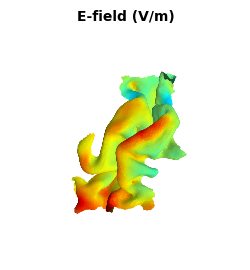

In [5]:
tempdata   = elm_Emagnitudes_interp
value_min, value_max = 0.0, 0.9
color_numPoint = 10000
color_name     = 'jet'

cmap           = plt.get_cmap('jet', lut=color_numPoint) # .reversed() 
list_color = plot_functions.calc_list_color(value_data=tempdata, value_min=value_min, value_max=value_max, \
                                           color_name=color_name, color_numPoint=color_numPoint, method='symmetry')
custom_cmap = ListedColormap(list_color)
# plot figures 
fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices_0[face] for face in faces_0], facecolors=list_color, edgecolors=list_color, shade=True)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(45, 180)
ax.axis('off')
ax.axis('equal')
ax.set_title('E-field (V/m)', fontsize=10, weight='bold')
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])

# save data for matlab plotting
surface = {'faces': faces_0 + 1, 'vertices': vertices_0}
value = tempdata
list_color_array = np.array([list(item[:3]) for item in list_color])
data = {'surface': surface, 'value': value, 'list_color': list_color_array}
dataPath = 'data_paper/data_matlab/L5SOI_magnE_smooth.mat'
if not os.path.exists(dataPath):
    scipy.io.savemat(dataPath, data)

In [25]:
indices_four_regions = np.load('data_paper/indices_of_four_regions_in_layer5SOI.npy', allow_pickle=True)
indices_four_regions = indices_four_regions.item()
indicesI   = indices_four_regions['indices_region_I']
indicesII  = indices_four_regions['indices_region_II']
indicesIII = indices_four_regions['indices_region_III']
indicesIV  = indices_four_regions['indices_region_IV']

print('E-field of four regions:')
data = elm_Emagnitudes_interp[indicesI]
print('Region I:  ', data.mean(), data.std())
data = elm_Emagnitudes_interp[indicesII]
print('Region II: ', data.mean(), data.std())
data = elm_Emagnitudes_interp[indicesIII]
print('Region III:', data.mean(), data.std())
data = elm_Emagnitudes_interp[indicesIV]
print('Region IV: ', data.mean(), data.std())

E-field of four regions:
Region I:   0.6908655077281924 0.08959362066014032
Region II:  0.6749352118570006 0.07079659075216863
Region III: 0.4662225087939462 0.05234778756061383
Region IV:  0.5376266410568138 0.04457992178671204


mean:  0.5273 std:  0.1034497220875919


[]

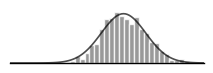

In [29]:
data = elm_Emagnitudes
min_value, max_value, num_value = 0., 0.9, 40
bin_counts, bin_edges = np.histogram(data, bins=np.linspace(min_value, max_value, num_value), density=True)
bin_centers           = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
width                 = (bin_edges[1] - bin_edges[0])
# gauss fitting
if 1:
    x, y = bin_centers, bin_counts
    data = {'x': x, 'y': y}
    scipy.io.savemat('data_matlab/test.mat', data)
x     = np.linspace(min_value, max_value, 100)
paras = [[3.883, 0.5273, 0.1463], ]  # paras = [[7.765, 0.2636, 0.07317], ]
y     = plot_functions.fit_gauss(x=x, paras=paras, order=1)
print('mean: ', paras[0][1], 'std: ', paras[0][2]/np.sqrt(2))
# plot figure
fig, ax = plt.subplots(1, 1, figsize=(2.5, 0.7))
ax.bar(bin_centers, bin_counts, width=width, color='gray', ec='white', alpha=0.8) # #005CA2
ax.plot(x, y, linewidth=1.2, color='k', alpha=0.7)
ax.set_xlim(0, 0.9)
ax.set_ylim(0, )
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.set_xticks([])
ax.set_yticks([])
# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure2a-2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

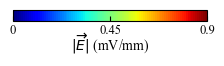

In [127]:
fig, ax = plt.subplots(1,1, figsize=(1.25, 0.14))
ax.axis('off')
cmap = plt.get_cmap('jet', lut=100)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
mappable.set_array([])
cbar = fig.colorbar(mappable, cax=ax.inset_axes([0., 0, 2, 1]), location='bottom', orientation='horizontal')
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['0', '0.45', '0.9'], fontdict={'family': 'times new roman', 'fontsize': 9})
cbar.ax.tick_params(direction='in', pad=3)
cbar.set_label(r'$|\overrightarrow{E}|$ (mV/mm)', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=-4)
plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure2a-3.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

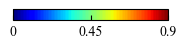

In [7]:
fig, ax = plt.subplots(1,1, figsize=(1, 0.14))
ax.axis('off')
cmap = plt.get_cmap('jet', lut=100)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
mappable.set_array([])
cbar = fig.colorbar(mappable, cax=ax.inset_axes([0., 0, 2, 1]), location='bottom', orientation='horizontal')
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['0', '0.45', '0.9'])
cbar.ax.tick_params(direction='in', pad=3, labelfontfamily='times new roman', labelsize=10)
# cbar.set_label(r'$|\overrightarrow{E}|$ (mV/mm)', fontdict={'family': 'times new roman', 'fontsize': 11}, labelpad=2)

plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure4Sc-2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure 2(b): PLV in layer 5 surface of interest (SOI)

In [6]:
# Load PLV and PPh, fr (1000 elements, uniform E-field extracted from the soma, scaling factor is 2)
dataPath = r'data_paper/L5PC_Clone4_PLV_ROISurf_tACS2mA10Hz_scalingFactor2_1000cells_uniform.p'
data = pickle.load(open(dataPath, 'rb'))
plv_roi_surf = np.array([item[0] for item in data])
pph_roi_surf = np.array([(np.angle(item[2])*180/np.pi + 360) % 360 for item in data])
fr_roi_surf  = np.array([item[5] for item in data])

# Linear interpolation for smoothing the data points
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], plv_roi_surf, function='linear')
plv_roi_surf_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], pph_roi_surf, function='linear')
pph_roi_surf_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], fr_roi_surf, function='linear')
fr_roi_surf_interp  = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])

# View the PLV distribution in SimNIBS
import simnibs
mesh_layer5_SOI = simnibs.read_msh(r'data_paper\Layer5_roi.msh')
elementData_class = simnibs.mesh_io.ElementData(plv_roi_surf_interp, name='plv', mesh=mesh_layer5_SOI)
mesh_layer5_SOI.elmdata.append(elementData_class)
elementData_class = simnibs.mesh_io.ElementData(pph_roi_surf_interp, name='pph', mesh=mesh_layer5_SOI)
mesh_layer5_SOI.elmdata.append(elementData_class)
elementData_class = simnibs.mesh_io.ElementData(fr_roi_surf_interp, name='fr', mesh=mesh_layer5_SOI)
mesh_layer5_SOI.elmdata.append(elementData_class)
# mesh_layer5_SOI.view().show()

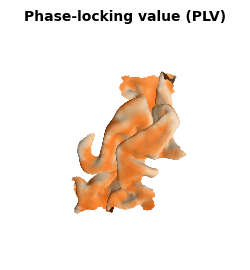

In [9]:
tempdata   = plv_roi_surf_interp
value_min, value_max = 0.008, 0.032
color_numPoint = 30000
color_name     = 'Oranges'

cmap           = plt.get_cmap(color_name, lut=color_numPoint) # .reversed() 
list_color = plot_functions.calc_list_color(value_data=tempdata, value_min=value_min, value_max=value_max, \
                                           color_name=color_name, color_numPoint=color_numPoint, method='symmetry')
custom_cmap = ListedColormap(list_color)
# plot figures 
fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices_0[face] for face in faces_0], facecolors=list_color, edgecolors=list_color, shade=True)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(45, 180)
ax.axis('off')
ax.axis('equal')
ax.set_title('Phase-locking value (PLV)', fontsize=10, weight='bold')

mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])

# save data for matlab plotting
surface = {'faces': faces_0 + 1, 'vertices': vertices_0}
value = tempdata
list_color_array = np.array([list(item[:3]) for item in list_color])
data = {'surface': surface, 'value': value, 'list_color': list_color_array}
dataPath = 'data_paper/data_matlab/L5SOI_PLV_uniformEF_smooth.mat'
if not os.path.exists(dataPath):
    scipy.io.savemat(dataPath, data)

In [10]:
indices_four_regions = np.load('data_paper/indices_of_four_regions_in_layer5SOI.npy', allow_pickle=True)
indices_four_regions = indices_four_regions.item()
indicesI   = indices_four_regions['indices_region_I']
indicesII  = indices_four_regions['indices_region_II']
indicesIII = indices_four_regions['indices_region_III']
indicesIV  = indices_four_regions['indices_region_IV']

print('PLV of four regions:')
data = plv_roi_surf_interp[indicesI]
print('Region I:  ', data.mean(), data.std())
data = plv_roi_surf_interp[indicesII]
print('Region II: ', data.mean(), data.std())
data = plv_roi_surf_interp[indicesIII]
print('Region III:', data.mean(), data.std())
data = plv_roi_surf_interp[indicesIV]
print('Region IV: ', data.mean(), data.std())

PLV of four regions:
Region I:   0.019629371405854048 0.003271749245315385
Region II:  0.020258116414549384 0.0036398463876174967
Region III: 0.021895274798073426 0.0031625740335568596
Region IV:  0.022124694856586587 0.0036029509433387536


mean: 0.017670890069729963 std: 0.004186844414656527
mean1: 0.02033 std1: 0.002001819297539116
mean2: 0.01334 std2: 0.0022160726522386398


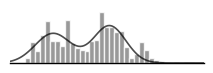

In [11]:
data = plv_roi_surf
min_value, max_value, num_value = 0.008, 0.032, 40
bin_counts, bin_edges = np.histogram(data, bins=np.linspace(min_value, max_value, num_value), density=True)
bin_centers           = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
width                 = (bin_edges[1] - bin_edges[0])
print('mean:', data.mean(), 'std:', data.std())
# gauss fitting
if 1:
    x, y = bin_centers, bin_counts
    data = {'x': x, 'y': y}
    scipy.io.savemat('data_matlab/test.mat', data)
x     = np.linspace(min_value, max_value, 100)
paras = [[105.1, 0.02033, 0.002831], [83.61, 0.01334, 0.003134], ]
y     = plot_functions.fit_gauss(x=x, paras=paras, order=2)
print('mean1:', 0.02033, 'std1:', 0.002831/np.sqrt(2))
print('mean2:', 0.01334, 'std2:', 0.003134/np.sqrt(2))
# plot figure
fig, ax = plt.subplots(1, 1, figsize=(2.5, 0.7))
ax.bar(bin_centers, bin_counts, width=width, color='gray', ec='white', alpha=0.8) # #005CA2
ax.plot(x, y, linewidth=1.2, color='k', alpha=0.7)
ax.set_xlim(min_value, max_value)
ax.set_ylim(0, )
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure2b-2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

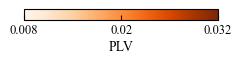

In [12]:
fig, ax = plt.subplots(1,1, figsize=(1.25, 0.14))
ax.axis('off')
cmap = plt.get_cmap('Oranges', lut=100)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
mappable.set_array([])
cbar = fig.colorbar(mappable, cax=ax.inset_axes([0., 0, 2, 1]), location='bottom', orientation='horizontal')
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['0.008', '0.02', '0.032'], fontdict={'family': 'times new roman', 'fontsize': 9})
cbar.ax.tick_params(direction='in', pad=3)
cbar.set_label('PLV', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2)
plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure2b-3.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure 2(c): PPh in layer 5 surface of interest (SOI)

In [18]:
indices_four_regions = np.load('data_paper/indices_of_four_regions_in_layer5SOI.npy', allow_pickle=True)
indices_four_regions = indices_four_regions.item()
indicesI   = indices_four_regions['indices_region_I']
indicesII  = indices_four_regions['indices_region_II']
indicesIII = indices_four_regions['indices_region_III']
indicesIV  = indices_four_regions['indices_region_IV']

print('PPh of four regions:')
data = pph_roi_surf_interp[indicesI]
print('Region I:  ', data.mean(), data.std())
data = pph_roi_surf_interp[indicesII]
print('Region II: ', data.mean(), data.std())
data = pph_roi_surf_interp[indicesIII]
print('Region III:', data.mean(), data.std())
data = pph_roi_surf_interp[indicesIV]
print('Region IV: ', data.mean(), data.std())

PPh of four regions:
Region I:   239.9545190155761 42.77528061498688
Region II:  219.7316631877637 42.59258559464493
Region III: 185.74581926061535 23.48352649096363
Region IV:  183.66840804855224 21.462380322976237


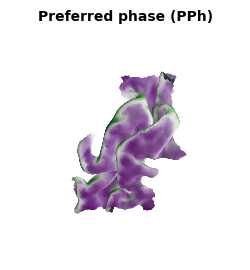

In [80]:
tempdata   = pph_roi_surf_interp
value_min, value_max = 150, 300
color_numPoint = 30000
color_name     = 'PRGn_r'

cmap           = plt.get_cmap(color_name, lut=color_numPoint) # .reversed() 
list_color = plot_functions.calc_list_color(value_data=tempdata, value_min=value_min, value_max=value_max, \
                                           color_name=color_name, color_numPoint=color_numPoint, method='symmetry')
custom_cmap = ListedColormap(list_color)
# plot figures 
fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices_0[face] for face in faces_0], facecolors=list_color, edgecolors=list_color, shade=True)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(45, 180)
ax.axis('off')
ax.axis('equal')
ax.set_title('Preferred phase (PPh)', fontsize=10, weight='bold')
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])

# save data for matlab plotting
surface = {'faces': faces_0 + 1, 'vertices': vertices_0}
value = tempdata
list_color_array = np.array([list(item[:3]) for item in list_color])
data = {'surface': surface, 'value': value, 'list_color': list_color_array}
dataPath = 'data_paper/data_matlab/L5SOI_PPh_uniformEF_smooth.mat'
if not os.path.exists(dataPath):
    scipy.io.savemat(dataPath, data)

mean: 235.3587774870982 std: 43.00939226013049
mean1: 275.1 std1: 4.890350498686162
mean2: 175.5 std2: 4.510634157188986


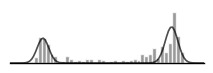

In [8]:
data = pph_roi_surf
min_value, max_value, num_value = 150, 300, 50
bin_counts, bin_edges = np.histogram(data, bins=np.linspace(min_value, max_value, num_value), density=True)
bin_centers           = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
width                 = (bin_edges[1] - bin_edges[0])
print('mean:', data.mean(), 'std:', data.std())
# gauss fitting
if 1:
    x, y = bin_centers, bin_counts
    data = {'x': x, 'y': y}
    scipy.io.savemat('data_matlab/test.mat', data)
x     = np.linspace(min_value, max_value, 100)
paras = [[0.03545, 275.1, 6.916], [0.02437, 175.5, 6.379], ] # R2 = 0.8843
y     = plot_functions.fit_gauss(x=x, paras=paras, order=2)
print('mean1:', paras[0][1], 'std1:', paras[0][2]/np.sqrt(2))
print('mean2:', paras[1][1], 'std2:', paras[1][2]/np.sqrt(2))
# plot figure
fig, ax = plt.subplots(1, 1, figsize=(2.5, 0.7))
ax.bar(bin_centers, bin_counts, width=width, color='gray', ec='white', alpha=0.8) # #005CA2
ax.plot(x, y, linewidth=1.2, color='k', alpha=0.7)
ax.set_xlim(min_value, max_value)
ax.set_ylim(0, )
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure2c-2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

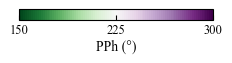

In [81]:
fig, ax = plt.subplots(1,1, figsize=(1.25, 0.14))
ax.axis('off')
cmap = plt.get_cmap('PRGn_r', lut=100)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
mappable.set_array([])
cbar = fig.colorbar(mappable, cax=ax.inset_axes([0., 0, 2, 1]), location='bottom', orientation='horizontal')
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['150', '225', '300'], fontdict={'family': 'times new roman', 'fontsize': 9})
cbar.ax.tick_params(direction='in', pad=3)
cbar.set_label('PPh (°)', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2)
plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure2c-3.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

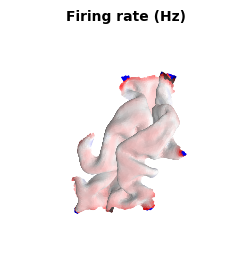

In [17]:
tempdata   = fr_roi_surf_interp
value_min, value_max = 10.3, 10.6
color_numPoint = 30000
color_name     = 'bwr'

cmap           = plt.get_cmap(color_name, lut=color_numPoint) # .reversed() 
list_color = plot_functions.calc_list_color(value_data=tempdata, value_min=value_min, value_max=value_max, \
                                           color_name=color_name, color_numPoint=color_numPoint, method='symmetry')
custom_cmap = ListedColormap(list_color)
# plot figures 
fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices_0[face] for face in faces_0], facecolors=list_color, edgecolors=list_color, shade=True)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(45, 180)
ax.axis('off')
ax.axis('equal')
ax.set_title('Firing rate (Hz)', fontsize=10, weight='bold')
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])

# # save data for matlab plotting
# surface = {'faces': faces_0 + 1, 'vertices': vertices_0}
# value = tempdata
# list_color_array = np.array([list(item[:3]) for item in list_color])
# data = {'surface': surface, 'value': value, 'list_color': list_color_array}
# dataPath = 'data_paper/data_matlab/L5SOI_firingRate_uniformEF_smooth.mat'
# if not os.path.exists(dataPath):
#     scipy.io.savemat(dataPath, data)

# Figure 2(d): Mollweide projection of E-field directions in layer 5 SOI

In [3]:
# Load E-fields at the center of elements (soma)
dataPath = r'data_paper\Layer5_popCell_interpolate_Evector_forSectionAndSegment.npy'
data = np.load(dataPath, allow_pickle=True).item()
popCell_Einterp_section = data['popCell_Einterp_section']
elm_Evectors = np.array([item[0] for item in popCell_Einterp_section]) # index 0 for soma compartment
elm_Emagnitudes = np.linalg.norm(elm_Evectors, axis=1)

# Load normals and centers of 1000 elements
dataPath     = 'data_paper/Layer5_popCell_sectionAndSegmentCoordinates.npy'
popCellInfo  = np.load(dataPath, allow_pickle=True).item()
cell_normals = popCellInfo['cell_normals']        # shape=(1000, 3)
cell_origins = popCellInfo['cell_origins'] * 1e3  # shape=(1000, 3), *1e3 for mm to μm
num_elements = len(cell_origins)

# Calculate the E-field direction relative to model neurons
list_theta, list_phi = plot_functions.calc_ROISurfEvec_toOriginEfieldDirection(elm_Evectors, cell_normals)

# Load indices of four regions
indices_four_regions = np.load('data_paper/indices_of_four_regions_in_layer5SOI.npy', allow_pickle=True)
indices_four_regions = indices_four_regions.item()
indicesI   = indices_four_regions['indices_region_I']
indicesII  = indices_four_regions['indices_region_II']
indicesIII = indices_four_regions['indices_region_III']
indicesIV  = indices_four_regions['indices_region_IV']
points_I   = np.unique(L5_surf_roi.find_closest_element(faces_center_0[indicesI], return_index=True)[1])
points_II  = np.unique(L5_surf_roi.find_closest_element(faces_center_0[indicesII], return_index=True)[1])
points_III = np.unique(L5_surf_roi.find_closest_element(faces_center_0[indicesIII], return_index=True)[1])
points_IV  = np.unique(L5_surf_roi.find_closest_element(faces_center_0[indicesIV], return_index=True)[1])

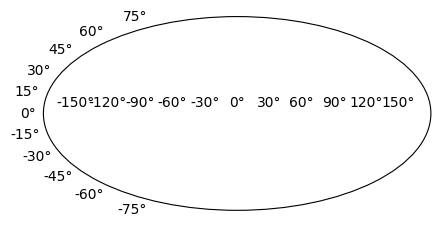

In [4]:
fig = plt.figure(figsize=(5, 4))
ax  = fig.add_subplot(1, 1, 1, projection="mollweide")

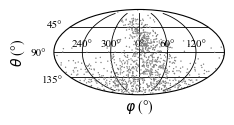

In [5]:
# list_phi = list_phi - 180
# list_phi[list_phi<0] += 360
xdata =  np.radians(list_phi)
ydata = -np.radians(list_theta - 90)
fig = plt.figure(figsize=(2.2, 3))
ax  = fig.add_subplot(1, 1, 1, projection="mollweide")
size = 1
ax.scatter(xdata, ydata, s=size, fc='gray', ec='None', zorder=1)
# ax.scatter(xdata[points_I], ydata[points_I], s=size+3, fc='r', ec='None', zorder=1)
# ax.scatter(xdata[points_II], ydata[points_II], s=size+3, fc='g', ec='None', zorder=1)
# ax.scatter(xdata[points_III], ydata[points_III], s=size+3, fc='b', ec='None', zorder=1)
# ax.scatter(xdata[points_IV], ydata[points_IV], s=size+3, fc='magenta', ec='None', zorder=1)
lw, color, zorder = 0.6, 'k', -1
ax.axhline(np.radians( -45), color=color, lw=lw, zorder=zorder)
ax.axhline(np.radians(   0), color=color, lw=lw, zorder=zorder)
ax.axhline(np.radians(  45), color=color, lw=lw, zorder=zorder)
ax.axvline(np.radians(-120), color=color, lw=lw, zorder=zorder)
ax.axvline(np.radians( -60), color=color, lw=lw, zorder=zorder)
ax.axvline(np.radians(   0), color=color, lw=lw, zorder=zorder)
ax.axvline(np.radians(  60), color=color, lw=lw, zorder=zorder)
ax.axvline(np.radians( 120), color=color, lw=lw, zorder=zorder)
ax.set_xticks(np.radians(np.arange(-120, 121, 60)))
# ax.set_xticklabels(['330°', '30°', '90°', '150°', '210°'])
ax.set_xticklabels(['240°', '300°', '0°', '60°', '120°'])
ax.set_yticks(np.radians(np.arange(-45, 46, 45)))
ax.set_yticklabels(['135°', '90°', '45°'])
ax.tick_params(labelsize=8, direction='in', pad=3, width=1, length=3, labelfontfamily='times new roman')

ax.set_xlabel(r'$\varphi$ (°)', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2 )
ax.set_ylabel(r'$\theta$ (°)', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2 )
plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure2d.tif', format='tif', transparent=True, dpi=600, bbox_inches='tight')

# Figure 2(e): PLV histogram at outward or inward E-field

In [10]:
# Load PLV and PPh, fr (1000 elements, uniform E-field extracted from the soma, scaling factor is 2)
dataPath     = r'data_paper/L5PC_Clone4_PLV_ROISurf_tACS2mA10Hz_scalingFactor2_1000cells_uniform.p'
data         = pickle.load(open(dataPath, 'rb'))
plv_roi_surf = np.array([item[0] for item in data])
pph_roi_surf = np.array([(np.angle(item[2])*180/np.pi + 360) % 360 for item in data])
fr_roi_surf  = np.array([item[5] for item in data])

# Load normals and centers of 1000 elements
dataPath     = 'data_paper/Layer5_popCell_sectionAndSegmentCoordinates.npy'
popCellInfo  = np.load(dataPath, allow_pickle=True).item()
cell_normals = popCellInfo['cell_normals']        # shape=(1000, 3)
cell_origins = popCellInfo['cell_origins'] * 1e3  # shape=(1000, 3), *1e3 for mm to μm
num_elements = len(cell_origins)

# Calculate the E-field direction relative to model neurons
list_theta, list_phi = plot_functions.calc_ROISurfEvec_toOriginEfieldDirection(elm_Evectors, cell_normals)
indices_upwardEF     = list_theta <= 90
indices_downwardEF   = list_theta > 90
indices_transverse   = np.logical_and(list_theta > 60, list_theta <= 120)

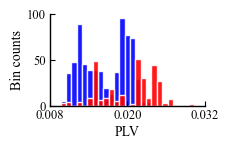

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(2., 1.2))
data = plv_roi_surf[indices_downwardEF]
min_value, max_value, num_value = 0.008, 0.032, 30
bin_counts, bin_edges = np.histogram(data, bins=np.linspace(min_value, max_value, num_value))
bin_centers           = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
width                 = (bin_edges[1] - bin_edges[0])
ax.bar(bin_centers, bin_counts, width=width, color='b', ec='white', alpha=0.9) # #005CA2

data = plv_roi_surf[indices_upwardEF]
min_value, max_value, num_value = 0.008, 0.032, 30
bin_counts, bin_edges = np.histogram(data, bins=np.linspace(min_value, max_value, num_value))
bin_centers           = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
width                 = (bin_edges[1] - bin_edges[0])
ax.bar(bin_centers, bin_counts, width=width, color='r', ec='white', alpha=0.9) # #EA700E


ax.set_xlim(min_value, max_value)
ax.set_ylim(0, )
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.set_xticks([0.008, 0.02, 0.032])
ax.set_yticks([0, 50, 100])
ax.tick_params(axis='both', direction='in', labelfontfamily='times new roman', labelsize=9, pad=3)
ax.set_xlabel('PLV', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2)
ax.set_ylabel('Bin counts', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2)
plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure2e.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure 2(f): PPh histogram at outward or inward E-field

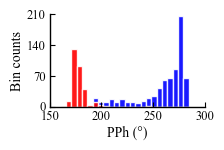

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(2., 1.2))
data = pph_roi_surf[indices_downwardEF]
min_value, max_value, num_value = 150, 300, 30
bin_counts, bin_edges = np.histogram(data, bins=np.linspace(min_value, max_value, num_value))
bin_centers           = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
width                 = (bin_edges[1] - bin_edges[0])
ax.bar(bin_centers, bin_counts, width=width, color='b', ec='white', alpha=0.9)

data = pph_roi_surf[indices_upwardEF]
min_value, max_value, num_value = 150, 300, 30
bin_counts, bin_edges = np.histogram(data, bins=np.linspace(min_value, max_value, num_value))
bin_centers           = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
width                 = (bin_edges[1] - bin_edges[0])
ax.bar(bin_centers, bin_counts, width=width, color='r', ec='white', alpha=0.9)


ax.set_xlim(150, 300)
ax.set_ylim(0, 210)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
# ax.set_xticks([0, 180, 360])
ax.set_yticks([0, 70, 140, 210])
ax.tick_params(axis='both', direction='in', labelfontfamily='times new roman', labelsize=9, pad=3)
ax.set_xlabel('PPh (°)', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2)
ax.set_ylabel('Bin counts', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2)
plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure2f.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure S2: Emagn, PLV, and PPh distribution in 7 regions

In [11]:
# layer 5 roi surface mesh with 1000 elements
L5_surf_roi  = simnibs.read_stl(r'data_paper\Layer5_roi_pymeshlab.stl')
faces        = L5_surf_roi.elm.node_number_list[:, 0:3] - 1
faces_center = L5_surf_roi.elements_baricenters().value
vertices     = L5_surf_roi.nodes.node_coord
# layer 5 roi surface mesh without discretized
L5_surf        = simnibs.read_msh(r'data_paper\Layer5_roi.msh')
faces_0        = L5_surf.elm.node_number_list[:, 0:3] - 1
faces_center_0 = L5_surf.elements_baricenters().value
vertices_0     = L5_surf.nodes.node_coord
# Load E-fields at the center of elements (soma)
dataPath = r'data_paper\Layer5_popCell_interpolate_Evector_forSectionAndSegment.npy'
data = np.load(dataPath, allow_pickle=True).item()
popCell_Einterp_section = data['popCell_Einterp_section']
elm_Evectors = np.array([item[0] for item in popCell_Einterp_section]) # index 0 for soma compartment
elm_Emagnitudes = np.linalg.norm(elm_Evectors, axis=1)
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], elm_Emagnitudes, function='linear')
elm_Emagnitudes_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# Load PLV and PPh, fr (1000 elements, uniform E-field extracted from the soma, scaling factor is 2)
dataPath = r'data_paper/L5PC_Clone4_PLV_ROISurf_tACS2mA10Hz_scalingFactor2_1000cells_uniform.p'
data = pickle.load(open(dataPath, 'rb'))
plv_roi_surf = np.array([item[0] for item in data])
pph_roi_surf = np.array([(np.angle(item[2])*180/np.pi + 360) % 360 for item in data])
fr_roi_surf  = np.array([item[5] for item in data])
# Linear interpolation for smoothing the data points
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], plv_roi_surf, function='linear')
plv_roi_surf_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], pph_roi_surf, function='linear')
pph_roi_surf_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], fr_roi_surf, function='linear')
fr_roi_surf_interp  = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# Load three structures indices
data_index = np.load('data/pre_central_post_indices_original.npy', allow_pickle=True).item()
precentral_indices  = data_index['precentral_indices']
central_indices     = data_index['central_indices']
postcentral_indices = data_index['postcentral_indices']
# Load three structures indices after downsampling
data_index = np.load('data/pre_central_post_indices_downsampling.npy', allow_pickle=True).item()
precentral_indices_sample  = data_index['precentral_indices']
central_indices_sample     = data_index['central_indices']
postcentral_indices_sample = data_index['postcentral_indices']
# Load four regions indices
indices_four_regions = np.load('data_paper/indices_of_four_regions_in_layer5SOI.npy', allow_pickle=True)
indices_four_regions = indices_four_regions.item()
indicesI   = indices_four_regions['indices_region_I']
indicesII  = indices_four_regions['indices_region_II']
indicesIII = indices_four_regions['indices_region_III']
indicesIV  = indices_four_regions['indices_region_IV']
# Load four regions indices after downsampling
indices_four_regions = np.load('data/indices_of_four_regions_in_layer5SOI_downsampling.npy', allow_pickle=True)
indices_four_regions = indices_four_regions.item()
indicesI_sample   = indices_four_regions['indices_region_I']
indicesII_sample  = indices_four_regions['indices_region_II']
indicesIII_sample = indices_four_regions['indices_region_III']
indicesIV_sample  = indices_four_regions['indices_region_IV']

In [5]:
list_7regions_indices = [precentral_indices, central_indices, postcentral_indices, indicesI, indicesII, indicesIII, indicesIV]
print('E-field: ---------')
for i, indices in enumerate(list_7regions_indices):
    print('%.3f±%.3f' % (np.mean(elm_Emagnitudes_interp[indices])*2, np.std(elm_Emagnitudes_interp[indices])*2))
print('PLV: -------------')
for i, indices in enumerate(list_7regions_indices):
    print('%.4f±%.4f' % (np.mean(plv_roi_surf_interp[indices]), np.std(plv_roi_surf_interp[indices])))
print('PPh: -------------')
for i, indices in enumerate(list_7regions_indices):
    print('%.2f±%.2f' % (np.mean(pph_roi_surf_interp[indices]), np.std(pph_roi_surf_interp[indices])))

E-field: ---------
0.566±0.099
0.501±0.084
0.538±0.113
0.691±0.090
0.675±0.071
0.466±0.052
0.538±0.045
PLV: -------------
0.0175±0.0034
0.0180±0.0038
0.0176±0.0036
0.0196±0.0033
0.0203±0.0036
0.0219±0.0032
0.0221±0.0036
PPh: -------------
232.58±38.56
226.02±41.86
238.92±37.99
239.95±42.78
219.73±42.59
185.75±23.48
183.67±21.46


In [6]:
list_7regions_indices = [precentral_indices_sample, central_indices_sample, postcentral_indices_sample, indicesI_sample, indicesII_sample, indicesIII_sample, indicesIV_sample]
print('E-field: ---------')
for i, indices in enumerate(list_7regions_indices):
    print('%.3f±%.3f' % (np.mean(elm_Emagnitudes[indices])*2, np.std(elm_Emagnitudes[indices])*2))
print('PLV: -------------')
for i, indices in enumerate(list_7regions_indices):
    print('%.4f±%.4f' % (np.mean(plv_roi_surf[indices]), np.std(plv_roi_surf[indices])))
print('PPh: -------------')
for i, indices in enumerate(list_7regions_indices):
    print('%.2f±%.2f' % (np.mean(pph_roi_surf[indices]), np.std(pph_roi_surf[indices])))

E-field: ---------
0.561±0.095
0.517±0.095
0.542±0.115
0.670±0.095
0.662±0.083
0.462±0.070
0.530±0.054
PLV: -------------
0.0175±0.0041
0.0180±0.0042
0.0177±0.0043
0.0194±0.0046
0.0201±0.0041
0.0206±0.0045
0.0206±0.0048
PPh: -------------
235.73±43.23
231.40±44.27
238.63±41.88
232.58±46.90
221.55±46.08
187.26±26.97
191.40±32.28


In [14]:
tempdata = elm_Emagnitudes
'''three anatomical regions'''
data1 = tempdata[precentral_indices_sample]*2
data2 = tempdata[central_indices_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('pre - central: ', t_stat, p_val)

data1 = tempdata[precentral_indices_sample]*2
data2 = tempdata[postcentral_indices_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('pre - post: ', t_stat, p_val)

data1 = tempdata[central_indices_sample]*2
data2 = tempdata[postcentral_indices_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('central - post: ', t_stat, p_val)

'''four self defined regions'''
data1 = tempdata[indicesI_sample]*2
data2 = tempdata[indicesII_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area I - area II: ', t_stat, p_val)

data1 = tempdata[indicesI_sample]*2
data2 = tempdata[indicesIII_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area I - area III: ', t_stat, p_val)

data1 = tempdata[indicesI_sample]*2
data2 = tempdata[indicesIV_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area I - area IV: ', t_stat, p_val)

data1 = tempdata[indicesII_sample]*2
data2 = tempdata[indicesIII_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area II - area III: ', t_stat, p_val)

data1 = tempdata[indicesII_sample]*2
data2 = tempdata[indicesIV_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area II - area IV: ', t_stat, p_val)

data1 = tempdata[indicesIII_sample]*2
data2 = tempdata[indicesIV_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area III - area IV: ', t_stat, p_val)

pre - central:  6.002368304503835 3.526879025927617e-09
pre - post:  2.0963062374444106 0.03647971134916561
central - post:  -3.3223829327459167 0.0009456027941104553
area I - area II:  0.47863012662398835 0.6332265540296768
area I - area III:  14.744789780200557 1.3775842503612613e-29
area I - area IV:  10.890215954370344 3.873561318768859e-20
area II - area III:  12.684103528133939 1.2112208313325204e-21
area II - area IV:  9.011971025360944 1.1087937599703468e-13
area III - area IV:  -5.357464593723266 5.914362006739538e-07


In [12]:
tempdata = plv_roi_surf
'''three anatomical regions'''
data1 = tempdata[precentral_indices_sample]*2
data2 = tempdata[central_indices_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('pre - central: ', t_stat, p_val)

data1 = tempdata[precentral_indices_sample]*2
data2 = tempdata[postcentral_indices_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('pre - post: ', t_stat, p_val)

data1 = tempdata[central_indices_sample]*2
data2 = tempdata[postcentral_indices_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('central - post: ', t_stat, p_val)

'''four self defined regions'''
data1 = tempdata[indicesI_sample]*2
data2 = tempdata[indicesII_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area I - area II: ', t_stat, p_val)

data1 = tempdata[indicesI_sample]*2
data2 = tempdata[indicesIII_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area I - area III: ', t_stat, p_val)

data1 = tempdata[indicesI_sample]*2
data2 = tempdata[indicesIV_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area I - area IV: ', t_stat, p_val)

data1 = tempdata[indicesII_sample]*2
data2 = tempdata[indicesIII_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area II - area III: ', t_stat, p_val)

data1 = tempdata[indicesII_sample]*2
data2 = tempdata[indicesIV_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area II - area IV: ', t_stat, p_val)

data1 = tempdata[indicesIII_sample]*2
data2 = tempdata[indicesIV_sample]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area III - area IV: ', t_stat, p_val)

pre - central:  -1.4489369589781724 0.14790435113965
pre - post:  -0.5238880048185377 0.6005576887710857
central - post:  0.9109188518504915 0.3626527342260306
area I - area II:  -0.8507157500730261 0.39698639640733147
area I - area III:  -1.4107155580609685 0.1612387887303104
area I - area IV:  -1.3245884627468925 0.1886865331323119
area II - area III:  -0.521208035534766 0.6034232368635406
area II - area IV:  -0.49871866759006755 0.6191994279794792
area III - area IV:  -0.005863240125615261 0.9953341683179775


In [66]:
tempdata = plv_roi_surf_interp
'''three anatomical regions'''
data1 = tempdata[precentral_indices]*2
data2 = tempdata[central_indices]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('pre - central: ', t_stat, p_val)

data1 = tempdata[precentral_indices]*2
data2 = tempdata[postcentral_indices]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('pre - post: ', t_stat, p_val)

data1 = tempdata[central_indices]*2
data2 = tempdata[postcentral_indices]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('central - post: ', t_stat, p_val)

'''four self defined regions'''
data1 = tempdata[indicesI]*2
data2 = tempdata[indicesII]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area I - area II: ', t_stat, p_val)

data1 = tempdata[indicesI]*2
data2 = tempdata[indicesIII]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area I - area III: ', t_stat, p_val)

data1 = tempdata[indicesI]*2
data2 = tempdata[indicesIV]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area I - area IV: ', t_stat, p_val)

data1 = tempdata[indicesII]*2
data2 = tempdata[indicesIII]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area II - area III: ', t_stat, p_val)

data1 = tempdata[indicesII]*2
data2 = tempdata[indicesIV]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area II - area IV: ', t_stat, p_val)

data1 = tempdata[indicesIII]*2
data2 = tempdata[indicesIV]*2
t_stat, p_val = scipy.stats.ttest_ind(data1, data2, equal_var=False)
print('area III - area IV: ', t_stat, p_val)

pre - central:  -8.42464159588611 4.0708143439364634e-17
pre - post:  -2.420308579948465 0.015524971761572543
central - post:  5.775173532630359 7.896479602647091e-09
area I - area II:  -3.4115234937333017 0.0006753125231333667
area I - area III:  -14.440760123571886 6.961764940630569e-44
area I - area IV:  -13.593882374008226 2.4257212235778815e-38
area II - area III:  -8.025873928310906 2.7122350289765084e-15
area II - area IV:  -8.291060279054397 3.458007542707415e-16
area III - area IV:  -1.128378169078951 0.259422105623588


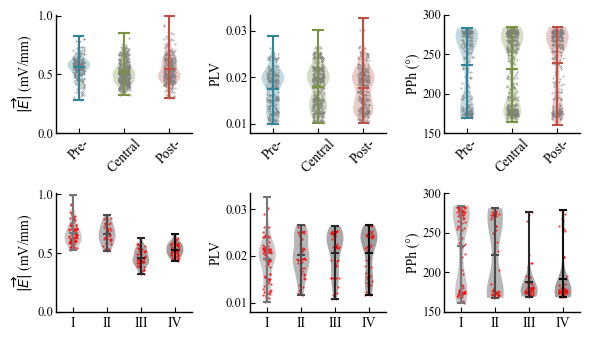

In [10]:
np.random.seed(21428)
fig, ax = plt.subplots(2, 3, figsize=(6, 3.5))
'''three structures'''
# axi = ax[0, 0]
# pc1 = axi.violinplot([elm_Emagnitudes_interp[precentral_indices]*2, elm_Emagnitudes_interp[central_indices]*2, elm_Emagnitudes_interp[postcentral_indices]*2], \
#                    positions=[0, 1, 2], widths=0.5, showmeans=True)
# axi = ax[0, 1]
# pc2 = axi.violinplot([plv_roi_surf_interp[precentral_indices], plv_roi_surf_interp[central_indices], plv_roi_surf_interp[postcentral_indices]], \
#                    positions=[0, 1, 2], widths=0.5, showmeans=True)
# axi = ax[0, 2]
# pc3 = axi.violinplot([pph_roi_surf_interp[precentral_indices], pph_roi_surf_interp[central_indices], pph_roi_surf_interp[postcentral_indices]], \
#                    positions=[0, 1, 2], widths=0.5, showmeans=True)


axi = ax[0, 0]
pc1 = axi.violinplot([elm_Emagnitudes[precentral_indices_sample]*2, elm_Emagnitudes[central_indices_sample]*2, elm_Emagnitudes[postcentral_indices_sample]*2], \
                   positions=[0, 1, 2], widths=0.5, showmeans=True)
axi = ax[0, 1]
pc2 = axi.violinplot([plv_roi_surf[precentral_indices_sample], plv_roi_surf[central_indices_sample], plv_roi_surf[postcentral_indices_sample]], \
                   positions=[0, 1, 2], widths=0.5, showmeans=True)
axi = ax[0, 2]
pc3 = axi.violinplot([pph_roi_surf[precentral_indices_sample], pph_roi_surf[central_indices_sample], pph_roi_surf[postcentral_indices_sample]], \
                   positions=[0, 1, 2], widths=0.5, showmeans=True)


s   = 0.1
fc  = 'gray'
axi = ax[0, 0]
plotdata = [elm_Emagnitudes[precentral_indices_sample]*2, elm_Emagnitudes[central_indices_sample]*2, elm_Emagnitudes[postcentral_indices_sample]*2]
for i in range(3):
    ydata = plotdata[i]
    xdata = (np.random.rand(len(ydata)) - 0.5) / 4 + i
    axi.scatter(xdata, ydata, s=s, ec=fc, fc=fc)
axi = ax[0, 1]
plotdata = [plv_roi_surf[precentral_indices_sample], plv_roi_surf[central_indices_sample], plv_roi_surf[postcentral_indices_sample]]
for i in range(3):
    ydata = plotdata[i]
    xdata = (np.random.rand(len(ydata)) - 0.5) / 4 + i
    axi.scatter(xdata, ydata, s=s, ec=fc, fc=fc)
axi = ax[0, 2]
plotdata = [pph_roi_surf[precentral_indices_sample], pph_roi_surf[central_indices_sample], pph_roi_surf[postcentral_indices_sample]]
for i in range(3):
    ydata = plotdata[i]
    xdata = (np.random.rand(len(ydata)) - 0.5) / 4 + i
    axi.scatter(xdata, ydata, s=s, ec=fc, fc=fc)



ax[0, 0].set_ylim(0, 1.01)
ax[0, 0].set_yticks([0, 0.5, 1])
ax[0, 1].set_ylim(0.008, 0.0335)
ax[0, 2].set_ylim(150, 300)

ax[0, 0].set_ylabel("$|\\overrightarrow{E}|$ (mV/mm)", fontsize=10, family='times new roman', labelpad=2)
ax[0, 1].set_ylabel("PLV", fontsize=10, family='times new roman', labelpad=2)
ax[0, 2].set_ylabel("PPh (°)", fontsize=10, family='times new roman', labelpad=2)

for item in [ax[0,0], ax[0,1], ax[0,2]]:
    item.set_xlim(-0.5, 2.5)
    item.set_xticks([0, 1, 2], labels=["Pre-", 'Central', "Post-"])
    item.spines['right'].set_color('none')
    item.spines['top'].set_color('none')
    item.spines['bottom'].set_linewidth(1)
    item.spines['left'].set_linewidth(1)
    item.tick_params(axis='x', direction='in', labelsize=10, labelfontfamily='times new roman', labelrotation=45, pad=2)
    item.tick_params(axis='y', direction='in', labelsize=9, labelfontfamily='times new roman', pad=2)

list_colors = ['#31859B', '#789440', '#C05046']
for pc in [pc1, pc2, pc3]:
    for item in ['cmeans', 'cmaxes', 'cmins', 'cbars']:
        pc[item].set_color(list_colors)
    for i in range(len(list_colors)):
        pc['bodies'][i].set_facecolor(list_colors[i])
        pc['bodies'][i].set_alpha(0.3)

'''four regions'''
# axi = ax[1, 0]
# pc4 = axi.violinplot([elm_Emagnitudes_interp[indicesI]*2, elm_Emagnitudes_interp[indicesII]*2, elm_Emagnitudes_interp[indicesIII]*2, elm_Emagnitudes_interp[indicesIV]*2], \
#                    positions=[0, 1, 2, 3], widths=0.5, showmeans=True)
# axi = ax[1, 1]
# pc5 = axi.violinplot([plv_roi_surf_interp[indicesI], plv_roi_surf_interp[indicesII], plv_roi_surf_interp[indicesIII], plv_roi_surf_interp[indicesIV]], \
#                    positions=[0, 1, 2, 3], widths=0.5, showmeans=True)
# axi = ax[1, 2]
# pc6 = axi.violinplot([pph_roi_surf_interp[indicesI], pph_roi_surf_interp[indicesII], pph_roi_surf_interp[indicesIII], pph_roi_surf_interp[indicesIV]], \
#                    positions=[0, 1, 2, 3], widths=0.5, showmeans=True)


axi = ax[1, 0]
pc4 = axi.violinplot([elm_Emagnitudes[indicesI_sample]*2, elm_Emagnitudes[indicesII_sample]*2, elm_Emagnitudes[indicesIII_sample]*2, elm_Emagnitudes[indicesIV_sample]*2], \
                   positions=[0, 1, 2, 3], widths=0.5, showmeans=True)
axi = ax[1, 1]
pc5 = axi.violinplot([plv_roi_surf[indicesI_sample], plv_roi_surf[indicesII_sample], plv_roi_surf[indicesIII_sample], plv_roi_surf[indicesIV_sample]], \
                   positions=[0, 1, 2, 3], widths=0.5, showmeans=True)
axi = ax[1, 2]
pc6 = axi.violinplot([pph_roi_surf[indicesI_sample], pph_roi_surf[indicesII_sample], pph_roi_surf[indicesIII_sample], pph_roi_surf[indicesIV_sample]], \
                   positions=[0, 1, 2, 3], widths=0.5, showmeans=True)

s, fc = 0.2, 'r'
axi = ax[1, 0]
plotdata = [elm_Emagnitudes[indicesI_sample]*2, elm_Emagnitudes[indicesII_sample]*2, elm_Emagnitudes[indicesIII_sample]*2, elm_Emagnitudes[indicesIV_sample]*2]
for i in range(4):
    ydata = plotdata[i]
    xdata = (np.random.rand(len(ydata)) - 0.5) / 4 + i
    axi.scatter(xdata, ydata, s=s, ec=fc, fc=fc)
axi = ax[1, 1]
plotdata = [plv_roi_surf[indicesI_sample], plv_roi_surf[indicesII_sample], plv_roi_surf[indicesIII_sample], plv_roi_surf[indicesIV_sample]]
for i in range(4):
    ydata = plotdata[i]
    xdata = (np.random.rand(len(ydata)) - 0.5) / 4 + i
    axi.scatter(xdata, ydata, s=s, ec=fc, fc=fc)
axi = ax[1, 2] 
plotdata = [pph_roi_surf[indicesI_sample], pph_roi_surf[indicesII_sample], pph_roi_surf[indicesIII_sample], pph_roi_surf[indicesIV_sample]]
for i in range(4):
    ydata = plotdata[i]
    xdata = (np.random.rand(len(ydata)) - 0.5) / 4 + i
    axi.scatter(xdata, ydata, s=s, ec=fc, fc=fc)
    

ax[1, 0].set_ylim(0, 1.01)
ax[1, 0].set_yticks([0, 0.5, 1])
ax[1, 1].set_ylim(0.008, 0.0335)
ax[1, 2].set_ylim(150, 300)

ax[1, 0].set_ylabel("$|\\overrightarrow{E}|$ (mV/mm)", fontsize=10, family='times new roman', labelpad=2)
ax[1, 1].set_ylabel("PLV", fontsize=10, family='times new roman', labelpad=2)
ax[1, 2].set_ylabel("PPh (°)", fontsize=10, family='times new roman', labelpad=2)

for item in [ax[1,0], ax[1,1], ax[1,2]]:
    item.set_xlim(-0.5, 3.5)
    item.set_xticks([0, 1, 2, 3], labels=["I", 'II', "III", "IV"])
    item.spines['right'].set_color('none')
    item.spines['top'].set_color('none')
    item.spines['bottom'].set_linewidth(1)
    item.spines['left'].set_linewidth(1)
    item.tick_params(axis='x', direction='in', labelsize=10, labelfontfamily='times new roman', labelrotation=0, pad=3)
    item.tick_params(axis='y', direction='in', labelsize=9, labelfontfamily='times new roman', pad=2)
    
list_colors = ['#777777', '#4D4D4D', '#292929', '#111111']
for pc in [pc4, pc5, pc6]:
    for item in ['cmeans', 'cmaxes', 'cmins', 'cbars']:
        pc[item].set_color(list_colors)
    for i in range(len(list_colors)):
        pc['bodies'][i].set_facecolor(list_colors[i])
        pc['bodies'][i].set_alpha(0.4)

plt.tight_layout(w_pad=1.2, h_pad=1)
plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figureS2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure S3: EF direction of four regions

In [69]:
# Load E-fields at the center of elements (soma)
dataPath = r'data_paper\Layer5_popCell_interpolate_Evector_forSectionAndSegment.npy'
data = np.load(dataPath, allow_pickle=True).item()
popCell_Einterp_section = data['popCell_Einterp_section']
elm_Evectors = np.array([item[0] for item in popCell_Einterp_section]) # index 0 for soma compartment
elm_Emagnitudes = np.linalg.norm(elm_Evectors, axis=1)

# Load normals and centers of 1000 elements
dataPath     = 'data_paper/Layer5_popCell_sectionAndSegmentCoordinates.npy'
popCellInfo  = np.load(dataPath, allow_pickle=True).item()
cell_normals = popCellInfo['cell_normals']        # shape=(1000, 3)
cell_origins = popCellInfo['cell_origins'] * 1e3  # shape=(1000, 3), *1e3 for mm to μm
num_elements = len(cell_origins)

# Calculate the E-field direction relative to model neurons
list_theta, list_phi = plot_functions.calc_ROISurfEvec_toOriginEfieldDirection(elm_Evectors, cell_normals)

# Load indices of four regions
indices_four_regions = np.load('data_paper/indices_of_four_regions_in_layer5SOI.npy', allow_pickle=True)
indices_four_regions = indices_four_regions.item()
indicesI   = indices_four_regions['indices_region_I']
indicesII  = indices_four_regions['indices_region_II']
indicesIII = indices_four_regions['indices_region_III']
indicesIV  = indices_four_regions['indices_region_IV']
points_I   = np.unique(L5_surf_roi.find_closest_element(faces_center_0[indicesI], return_index=True)[1])
points_II  = np.unique(L5_surf_roi.find_closest_element(faces_center_0[indicesII], return_index=True)[1])
points_III = np.unique(L5_surf_roi.find_closest_element(faces_center_0[indicesIII], return_index=True)[1])
points_IV  = np.unique(L5_surf_roi.find_closest_element(faces_center_0[indicesIV], return_index=True)[1])

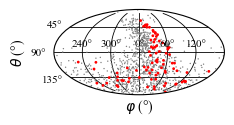

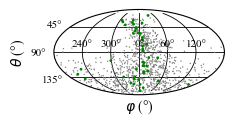

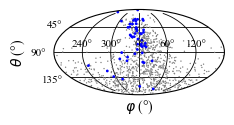

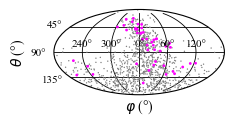

In [71]:
# list_phi = list_phi - 180
# list_phi[list_phi<0] += 360
xdata =  np.radians(list_phi)
ydata = -np.radians(list_theta - 90)
for i in range(1, 5):
    fig = plt.figure(figsize=(2.2, 3))
    ax  = fig.add_subplot(1, 1, 1, projection="mollweide")
    size = 1
    ax.scatter(xdata, ydata, s=size, fc='gray', ec='None', zorder=1)
    if i == 1:
        ax.scatter(xdata[points_I], ydata[points_I], s=size+3, fc='r', ec='None', zorder=1)
    if i == 2:
        ax.scatter(xdata[points_II], ydata[points_II], s=size+3, fc='g', ec='None', zorder=1)
    if i == 3:
        ax.scatter(xdata[points_III], ydata[points_III], s=size+3, fc='b', ec='None', zorder=1)
    if i == 4:
        ax.scatter(xdata[points_IV], ydata[points_IV], s=size+3, fc='magenta', ec='None', zorder=1)
    lw, color, zorder = 0.6, 'k', -1
    ax.axhline(np.radians( -45), color=color, lw=lw, zorder=zorder)
    ax.axhline(np.radians(   0), color=color, lw=lw, zorder=zorder)
    ax.axhline(np.radians(  45), color=color, lw=lw, zorder=zorder)
    ax.axvline(np.radians(-120), color=color, lw=lw, zorder=zorder)
    ax.axvline(np.radians( -60), color=color, lw=lw, zorder=zorder)
    ax.axvline(np.radians(   0), color=color, lw=lw, zorder=zorder)
    ax.axvline(np.radians(  60), color=color, lw=lw, zorder=zorder)
    ax.axvline(np.radians( 120), color=color, lw=lw, zorder=zorder)
    ax.set_xticks(np.radians(np.arange(-120, 121, 60)))
    # ax.set_xticklabels(['330°', '30°', '90°', '150°', '210°'])
    ax.set_xticklabels(['240°', '300°', '0°', '60°', '120°'])
    ax.set_yticks(np.radians(np.arange(-45, 46, 45)))
    ax.set_yticklabels(['135°', '90°', '45°'])
    ax.tick_params(labelsize=8, direction='in', pad=3, width=1, length=3, labelfontfamily='times new roman')
    
    ax.set_xlabel(r'$\varphi$ (°)',fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2 )
    ax.set_ylabel(r'$\theta$ (°)',fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2 )
    plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figureS2B-%d.tif' % i,format='tif',transparent=True,dpi=600,bbox_inches='tight')

In [19]:
# layer 5 roi surface mesh with 1000 elements
L5_surf_roi  = simnibs.read_stl(r'data_paper\Layer5_roi_pymeshlab.stl')
faces        = L5_surf_roi.elm.node_number_list[:, 0:3] - 1
faces_center = L5_surf_roi.elements_baricenters().value
vertices     = L5_surf_roi.nodes.node_coord
# layer 5 roi surface mesh without discretized
L5_surf        = simnibs.read_msh(r'data_paper\Layer5_roi.msh')
faces_0        = L5_surf.elm.node_number_list[:, 0:3] - 1
faces_center_0 = L5_surf.elements_baricenters().value
vertices_0     = L5_surf.nodes.node_coord
# Load E-fields at the center of elements (soma)
dataPath = r'data_paper\Layer5_popCell_interpolate_Evector_forSectionAndSegment.npy'
data = np.load(dataPath, allow_pickle=True).item()
popCell_Einterp_section = data['popCell_Einterp_section']
elm_Evectors = np.array([item[0] for item in popCell_Einterp_section]) # index 0 for soma compartment
elm_Emagnitudes = np.linalg.norm(elm_Evectors, axis=1)
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], elm_Emagnitudes, function='linear')
elm_Emagnitudes_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# Load PLV and PPh, fr (1000 elements, uniform E-field extracted from the soma, scaling factor is 2)
dataPath = r'data_paper/L5PC_Clone4_PLV_ROISurf_tACS2mA10Hz_scalingFactor2_1000cells_uniform.p'
data = pickle.load(open(dataPath, 'rb'))
plv_roi_surf = np.array([item[0] for item in data])
pph_roi_surf = np.array([(np.angle(item[2])*180/np.pi + 360) % 360 for item in data])
fr_roi_surf  = np.array([item[5] for item in data])
# Linear interpolation for smoothing the data points
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], plv_roi_surf, function='linear')
plv_roi_surf_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], pph_roi_surf, function='linear')
pph_roi_surf_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], fr_roi_surf, function='linear')
fr_roi_surf_interp  = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# Load three structures indices
data_index = np.load('data/pre_central_post_indices_original.npy', allow_pickle=True).item()
precentral_indices  = data_index['precentral_indices']
central_indices     = data_index['central_indices']
postcentral_indices = data_index['postcentral_indices']
# Load four regions indices
indices_four_regions = np.load('data_paper/indices_of_four_regions_in_layer5SOI.npy', allow_pickle=True)
indices_four_regions = indices_four_regions.item()
indicesI   = indices_four_regions['indices_region_I']
indicesII  = indices_four_regions['indices_region_II']
indicesIII = indices_four_regions['indices_region_III']
indicesIV  = indices_four_regions['indices_region_IV']